# Introduction
Thus far, I have written about ways to transform and encode numeric features, and to geocode and develop clusters of resale flats. These two steps generated new categorical features. In this post, I will demonstrate several ways to encode categorical features for our machine learning model.

In [1]:
# Import modules
import category_encoders as ce
from IPython.display import Image  
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import seaborn.apionly as sns
from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
import warnings

# Settings
%matplotlib inline
warnings.filterwarnings('ignore')

# Read data
hdb = pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2015-onwards.csv')

# Recap on New Features Generated
  
## Numeric Features
In my [first post](https://chrischow.github.io/dataandstuff/2018-09-08-hdb-feature-engineering-i/) on feature engineering, we looked at (1) transformation of non-normal features and (2) binning. Specifically, for (1), we performed a log transformation of the target (resale prices); for (2), we looked at fixed-width binning, quantile binning, and decision tree binning, with the latter two being preferred. For this post, I will use decision tree binning to convert floor area into a categorical feature for the purpose of demonstrating categorical feature encoding techniques.
  
First, we re-fit the decision tree to obtain the criteria for the respective bins.

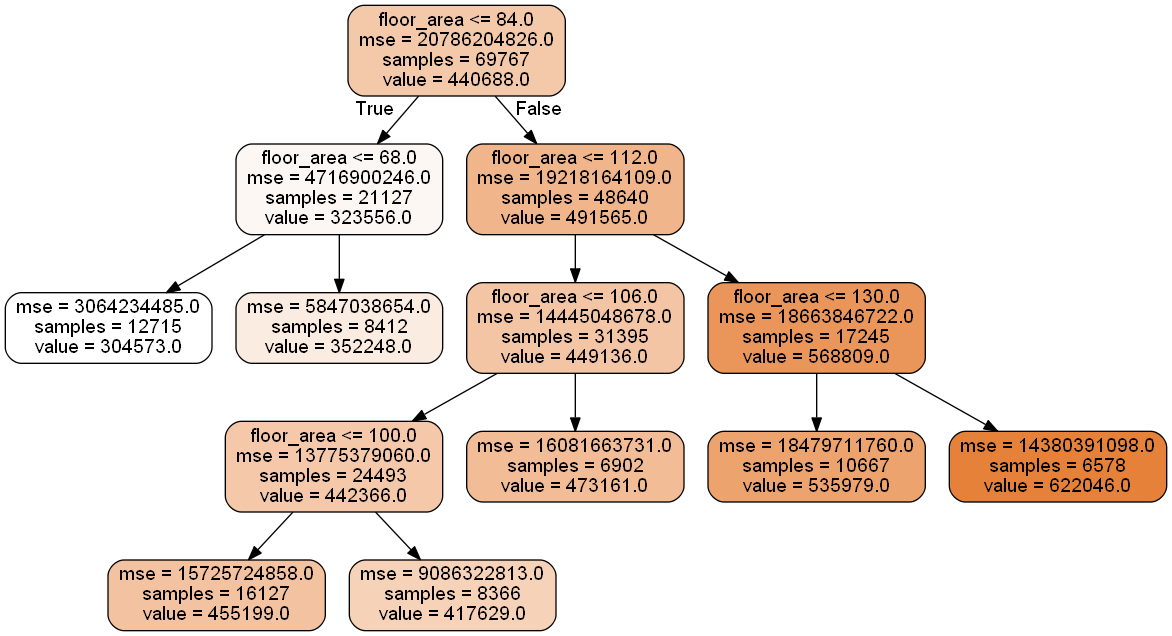

In [2]:
# Prepare data
y_train = hdb.resale_price
X_train = hdb[['floor_area_sqm']]

# Configure decision tree regressor
dt_model = DecisionTreeRegressor(
    criterion = 'mse',
    max_depth = 4,
    min_samples_leaf = 6500,
    random_state = 123
)

# Fit data
dt_model.fit(X_train, y_train)

# Plot
dot_data = tree.export_graphviz(
    dt_model, feature_names=['floor_area'],
    out_file=None, filled=True,
    rounded=True, precision = 0
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png(), width = 750)

Next, we extract the leaf node IDs using the `apply` function from our decision tree regressor model. We then rename the categories in order of their predicted mean value.

In [3]:
# Extract end nodes
hdb['floor_area'] = dt_model.apply(X_train)

# Re-name end nodes
hdb['floor_area'][hdb.floor_area == 2] = 1
hdb['floor_area'][hdb.floor_area == 3] = 2
hdb['floor_area'][hdb.floor_area == 7] = 3
hdb['floor_area'][hdb.floor_area == 8] = 4
hdb['floor_area'][hdb.floor_area == 9] = 5
hdb['floor_area'][hdb.floor_area == 11] = 6
hdb['floor_area'][hdb.floor_area == 12] = 7
hdb['floor_area'] = 'C' + hdb.floor_area.astype('str')

## Geocoding and Clusters
In my [second post](http://www.google.com) on feature engineering, we looked at how we could extract much more information from the addresses provided in the dataset. We constructed addresses using the block numbers and street names, ran them through the [HERE API](https://developer.here.com/) to obtain geographic coordinates, and ran those through K-Means clustering to obtain clusters for each of the 26 towns in the dataset. Below, we re-generate and attach the clusters to the main dataset.

In [4]:
# Load coordinates
map_latlon = pd.read_csv('latlon_data.csv')

# Set index to address
map_latlon = map_latlon.rename({'address': 'search_address'})
map_latlon = map_latlon.set_index('address')

# Separate the mappings
map_lat = map_latlon['lat']
map_lon = map_latlon['lon']

# Create search address feature
hdb['search_address'] = hdb.block + '+' + hdb.street_name.str.replace(' ', '+') + '+SINGAPORE'

# Map coordinates to main dataset
hdb['lat'] = hdb.search_address.map(map_lat)
hdb['lon'] = hdb.search_address.map(map_lon)

# Optimal clusters
clust_results = [7, 5, 6, 7, 7, 4, 5, 6, 5, 5, 3, 6, 5, 7, 7, 6, 6, 5, 5, 8, 5, 5, 4, 2, 1, 2]

# Create dataframe
disp_clust = pd.DataFrame(
    [hdb.town.value_counts().index, clust_results], index = ['Town', 'Clusters']
).T.set_index('Town')

# Get list of towns
all_towns = hdb.town.value_counts().index

# Initialise cluster feature
hdb['cluster'] = 0

# Loop through
for town in all_towns:
    
    # Extract town data
    temp_dat = hdb[['lat', 'lon']][hdb.town == town]
    temp_dat = temp_dat.reset_index(drop = True)

    # Normalise
    temp_mm = MinMaxScaler()
    temp_mm.fit(temp_dat)
    temp_dat_scaled = pd.DataFrame(temp_mm.transform(temp_dat), columns = ['lat', 'lon'])
    
    # Get optimal clusters
    opt_clust = disp_clust.loc[town][0]
    
    # Fit optimal clusters:
    temp_km = KMeans(n_clusters = opt_clust, random_state = 123)
    temp_km.fit(temp_dat_scaled)
    
    # Attach labels
    hdb['cluster'][hdb.town == town] = temp_km.labels_ + 1

# Rename cluster feature
hdb['cluster'] = hdb.town.str.replace(' ', '_').replace('/', '_') + hdb.cluster.astype('str')

# Save data
hdb.to_csv('hdb_categorical.csv',index=False)

With that, we have generated two categorical features that I will use to demonstrate several categorical feature encoding techniques:  
  
* `floor_area`: Decision tree bins for floor area
* `cluster`: Cluster within towns  
  

Before we begin, let's clean up the dataset for easy previewing:

In [5]:
# Re-load data
hdb = pd.read_csv('hdb_categorical.csv')

# Delete unwanted columns
hdb = hdb.drop(['month', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model',
              'lease_commence_date', 'remaining_lease', 'search_address', 'lat', 'lon'], axis = 1)

# Categorical Feature Encoding Techniques
There are two types of categorical features: **nominal** and **ordinal** features. Nominal features do not have any order to them. An example of this would be the clusters we developed. Ang Mo Kio Clusters 1 and 2 have no ordinal relation other than the arbitrary numbering I gave them. Ordinal features have some meaningful order behind them. Our decision tree bins can be thought of as an ordinal feature because bin 1 contains resale flats with the smallest floor area, while bin 7 contains resale flats with the largest floor area.

## Ordinal Encoding
The first and most intuitive way to encode a categorical feature is to assign integers to each category. This applies mainly to **ordinal** features, since there is some hierarchy among the categories. Since we have 7 bins for floor area, we can encode it with the numbers 1 to 7. A decision tree model can process this by making splits between 1 and 7, or by singling out categories (e.g. `floor_cat_ordinal == 7 vs. floor_cat_ordinal != 7`).  

In [6]:
# Reset data
df = hdb.copy()

# Get categories
all_cats = sorted(df.floor_area.unique())

# Convert floor_cat to ordinal feature
df['fa_ord'] = df.floor_area.astype('category', ordered = True, categories = all_cats).cat.codes + 1

# Preview
df.groupby('fa_ord').head(1).sort_values(by = 'fa_ord')

town  floor_area_sqm  resale_price floor_area      cluster  fa_ord
0    ANG MO KIO            60.0      255000.0         C1  ANG_MO_KIO3       1
2    ANG MO KIO            69.0      285000.0         C2  ANG_MO_KIO1       2
32   ANG MO KIO            92.0      385000.0         C3  ANG_MO_KIO5       3
118       BEDOK           103.0      418000.0         C4       BEDOK5       4
57   ANG MO KIO           110.0      755000.0         C5  ANG_MO_KIO4       5
51   ANG MO KIO           125.0      533000.0         C6  ANG_MO_KIO1       6
53   ANG MO KIO           138.0      580000.0         C7  ANG_MO_KIO1       7

Note that we could also employ the same approach for a nominal feature. However, the numbers assigned would be purely arbitrary. As such, there may not be much intuition in applying ordinal encoding to nominal features.

## One-Hot Encoding
The second way to encode a categorical feature is using one-hot encoding. This involves creating a new feature for every category, and setting each feature to 1 if the observation corresponds to that category and 0 otherwise. In other words, we create one binary feature per category.

In [7]:
# Reset data
df = hdb.copy()

# One-hot encoding
df = pd.concat([df, pd.get_dummies(df[['floor_area']])], axis = 1)

# Drop unused columns
df = df.drop(['town', 'floor_area_sqm', 'resale_price', 'cluster'], axis = 1)

# View
df.groupby('floor_area').head(1).sort_values(by = 'floor_area')

floor_area  floor_area_C1  floor_area_C2  floor_area_C3  floor_area_C4  \
0           C1              1              0              0              0   
2           C2              0              1              0              0   
32          C3              0              0              1              0   
118         C4              0              0              0              1   
57          C5              0              0              0              0   
51          C6              0              0              0              0   
53          C7              0              0              0              0   

     floor_area_C5  floor_area_C6  floor_area_C7  
0                0              0              0  
2                0              0              0  
32               0              0              0  
118              0              0              0  
57               1              0              0  
51               0              1              0  
53               0              0              1

The downside to using this technique is that we end up adding many sparse features (many zeros) to the dataset. Imagine what would happen if we were to apply this approach to nominal features: we would have 134 new features to analyse. Fortunately, there is a neat way to generate fewer binary features: binary encoding.

## Binary Encoding
Binary encoding converts integers into their bitstrings, and generates one binary feature per digit. I'll demonstrate this on the cluster feature to show how effective it is on categorical features with high cardinality.

In [8]:
# Reset data
df = hdb.copy()

# Set up binary encoder
hdb_binary = ce.binary.BinaryEncoder()

# Calculate digits:
# hdb_binary.calc_required_digits(X = df[['cluster']], col = 'cluster')
# Output: 9

# Fit, transform, and append features
df = pd.concat([df, hdb_binary.fit_transform(df[['cluster']])], axis = 1)

# Drop unused columns
df = df.drop(['floor_area_sqm', 'resale_price', 'floor_area'], axis = 1)

# Add binary number
df['binary'] = df.cluster_0.astype('str') + \
    df.cluster_1.astype('str') + \
    df.cluster_2.astype('str') + \
    df.cluster_3.astype('str') + \
    df.cluster_4.astype('str') + \
    df.cluster_5.astype('str') + \
    df.cluster_6.astype('str') + \
    df.cluster_7.astype('str') + \
    df.cluster_8.astype('str')

# View
df.groupby('town').head(1).head()

town       cluster  cluster_0  cluster_1  cluster_2  cluster_3  \
0     ANG MO KIO   ANG_MO_KIO3          0          0          0          0   
59         BEDOK        BEDOK5          0          0          0          0   
148       BISHAN       BISHAN4          0          0          0          0   
173  BUKIT BATOK  BUKIT_BATOK2          0          0          0          0   
234  BUKIT MERAH  BUKIT_MERAH5          0          0          0          0   

     cluster_4  cluster_5  cluster_6  cluster_7  cluster_8     binary  
0            0          0          0          0          1  000000001  
59           0          0          1          1          0  000000110  
148          0          1          1          0          1  000001101  
173          1          0          0          0          1  000010001  
234          1          0          1          0          0  000010100

Using binary encoding, we convert a feature with 134 categories into only 8 binary features. The columns `cluster_1` to `cluster_8` correspond to the binary version of the integer assigned to the cluster feature (captured in the `binary` feature for demonstration purposes only). In this case, `ANG_MO_KIO3` has been coded arbitrarily as the number 1, while `BISHAN4` has been coded as the number 13.

## Contrast Coding
Contrast coding is about comparing the mean of the target (resale price) for a given category (e.g. category 1 in floor area) against the mean of the means of the target for all categories. That sounds confusing, but it really isn't. First, let's calculate the mean of the target for each floor area category:

In [9]:
# Reset data
df = hdb.copy()

# Calculate target means across floor area categories
floor_area_means = pd.DataFrame(df.groupby('floor_area').resale_price.mean())

# View
floor_area_means

resale_price
floor_area               
C1          304573.420675
C2          352248.416638
C3          455199.014743
C4          417628.500689
C5          473160.796673
C6          535978.644477
C7          622046.397215

Next, we calculate the grand mean - the mean of the means above - and subtract it from the individual means:

In [10]:
# Calculate grand mean
grand_mean = floor_area_means.mean()

# Subtract
floor_area_means - grand_mean

resale_price
floor_area               
C1         -146974.463770
C2          -99299.467806
C3            3651.130299
C4          -33919.383756
C5           21612.912229
C6           84430.760033
C7          170498.512771

The numbers above are essentially the coefficients on the encoded features when we run a linear regression of resale price against them. What goes on behind the scenes is the following: we simply generate *n - 1* features to represent the comparison of their target means to the grand mean, with one category omitted from the comparison (in this case, category 4, which has many instances of `-1`).

In [11]:
# Set up sum encoder
hdb_sum = ce.sum_coding.SumEncoder()

# Fit, transform, and append features
df = pd.concat([df, hdb_sum.fit_transform(X = df[['floor_area']], y = df.resale_price)], axis = 1)

# Remove unused columns
df = df.drop(['town', 'floor_area_sqm', 'resale_price', 'cluster'], axis = 1)

# View
df.groupby('floor_area').head(1).sort_values(by = 'floor_area')

floor_area  col_floor_area_0  col_floor_area_1  col_floor_area_2  \
0           C1               1.0               1.0               0.0   
2           C2               1.0               0.0               1.0   
32          C3               1.0               0.0               0.0   
118         C4               1.0              -1.0              -1.0   
57          C5               1.0               0.0               0.0   
51          C6               1.0               0.0               0.0   
53          C7               1.0               0.0               0.0   

     col_floor_area_3  col_floor_area_4  col_floor_area_5  col_floor_area_6  
0                 0.0               0.0               0.0               0.0  
2                 0.0               0.0               0.0               0.0  
32                1.0               0.0               0.0               0.0  
118              -1.0              -1.0              -1.0              -1.0  
57                0.0               0.0               0.0               1.0  
51                0.0               1.0               0.0               0.0  
53                0.0               0.0               1.0               0.0

There are several other techniques that involve comparison of means. Helmert encoding, Reverse Helmert Encoding, Backward Difference Encoding, and Forward Difference Encoding all compare the target mean of one category with the mean of the target for other categories or groups of categories. Understanding Contrast Encoding is sufficient to understand the core concept of comparing means. Hence, we need not dive into the above techniques. Nevertheless, it is worth testing them out on your own if you wish to experiment with more categorical encoding schemes.

## Stats Encoding
Stats encoding requires us to replace each category with some statistic about the target. For example, we could add the mean, standard deviation, and coefficient of variation of the target for each floor area category.
  
***Note:** I performed the log transformation on resale prices before calculating the statistics.*

In [12]:
# Reset data
df = hdb.copy()

# Log transform resale price
df['log_price'] = np.log(df.resale_price)

# Calculate means
fa_means = df.groupby('floor_area').log_price.mean()

# Calculate standard deviations
fa_std = df.groupby('floor_area').log_price.std()

# Calculate coefficients of variation
fa_cv = fa_std / fa_means

# Create new features
df['fa_means'] = df.floor_area.map(fa_means)
df['fa_std'] = df.floor_area.map(fa_std)
df['fa_cv'] = df.floor_area.map(fa_cv)

# Drop unused features
df = df.drop(['town', 'floor_area_sqm', 'cluster', 'resale_price'], axis = 1)

# View
df.groupby('floor_area').head(1).sort_values('floor_area')

floor_area  log_price   fa_means    fa_std     fa_cv
0           C1  12.449019  12.612001  0.167384  0.013272
2           C2  12.560244  12.751954  0.194041  0.015217
32          C3  12.860999  12.996433  0.243862  0.018764
118         C4  12.943237  12.921575  0.194310  0.015038
57          C5  13.534473  13.039018  0.224441  0.017213
51          C6  13.186277  13.163824  0.229672  0.017447
53          C7  13.270783  13.323070  0.186554  0.014002

Stats encoding enables us to convert categorical features back into numeric features and save on the total number of features added to the dataset, especially when the categorical feature being converted is of high cardinality. For example, using the same computations above, the cluster feature is expanded to only three columns:

In [13]:
# Reset data
df = hdb.copy()

# Log transform resale price
df['log_price'] = np.log(df.resale_price)

# Calculate means
cl_means = df.groupby('cluster').log_price.mean()

# Calculate standard deviations
cl_std = df.groupby('cluster').log_price.std()

# Calculate coefficients of variation
cl_cv = cl_std / cl_means

# Create new features
df['cl_means'] = df.cluster.map(cl_means)
df['cl_std'] = df.cluster.map(cl_std)
df['cl_cv'] = df.cluster.map(cl_cv)

# Drop unused features
df = df.drop(['floor_area_sqm', 'floor_area', 'resale_price'], axis = 1)

# View
df.groupby('town').head(1).sort_values('cluster').head()

town       cluster  log_price   cl_means    cl_std     cl_cv
0     ANG MO KIO   ANG_MO_KIO3  12.449019  12.806781  0.292011  0.022801
59         BEDOK        BEDOK5  12.413087  12.776089  0.274420  0.021479
148       BISHAN       BISHAN4  12.879017  13.062051  0.351218  0.026888
173  BUKIT BATOK  BUKIT_BATOK2  12.449019  12.792429  0.263350  0.020586
234  BUKIT MERAH  BUKIT_MERAH5  12.542545  13.133030  0.424531  0.032325

# Feature Interactions
In this section, we explore meaningful interactions between features using decision trees. I demonstrate this using flat type and floor area categories. To begin, we need to group some flat types together because there are two categories that have very few observations (1-room and multi-generation flats). We attach them to the next closest categories (2-room and executive flats).

In [41]:
# Re-load data
hdb = pd.read_csv('hdb_categorical.csv')

# View
hdb.pivot_table(
    values = 'floor_area_sqm',
    index = 'flat_type',
    aggfunc = [len, np.mean, np.median]
).rename(columns = {'len': 'count'})

count        mean  median
flat_type                                    
1 ROOM               28.0   31.000000    31.0
2 ROOM              725.0   45.366897    45.0
3 ROOM            17886.0   68.408750    67.0
4 ROOM            28612.0   95.887191    94.0
5 ROOM            16885.0  118.262718   119.0
EXECUTIVE          5618.0  144.000000   145.0
MULTI-GENERATION     13.0  162.384615   164.0

In [43]:
# Attach 1-room flat to 2-room flat category
hdb['flat_type'][hdb.flat_type == '1 ROOM'] = '2 ROOM'

# Attach 1-room flat to 2-room flat category
hdb['flat_type'][hdb.flat_type == 'MULTI-GENERATION'] = 'EXECUTIVE'

# View
hdb.pivot_table(
    values = 'floor_area_sqm',
    index = 'flat_type',
    aggfunc = [len, np.mean, np.median]
).rename(columns = {'len': 'count'})

Combining the 5 flat types and 7 floor area categories, we obtain 20 combined categories. This is because some flat types and floor area categories are not compatible e.g. 1-room and C7, the largest floor area category. I performed one-hot encoding on the features to convert them to a usable form for the decision tree. Then, I set the`min_samples_leaf` parameter, which is the minimum number of samples in an end node, to be 1/35th of the data (about 2,000). I also increase `max_depth`, the maximum depth of the tree, to 20 to allow for more end nodes.

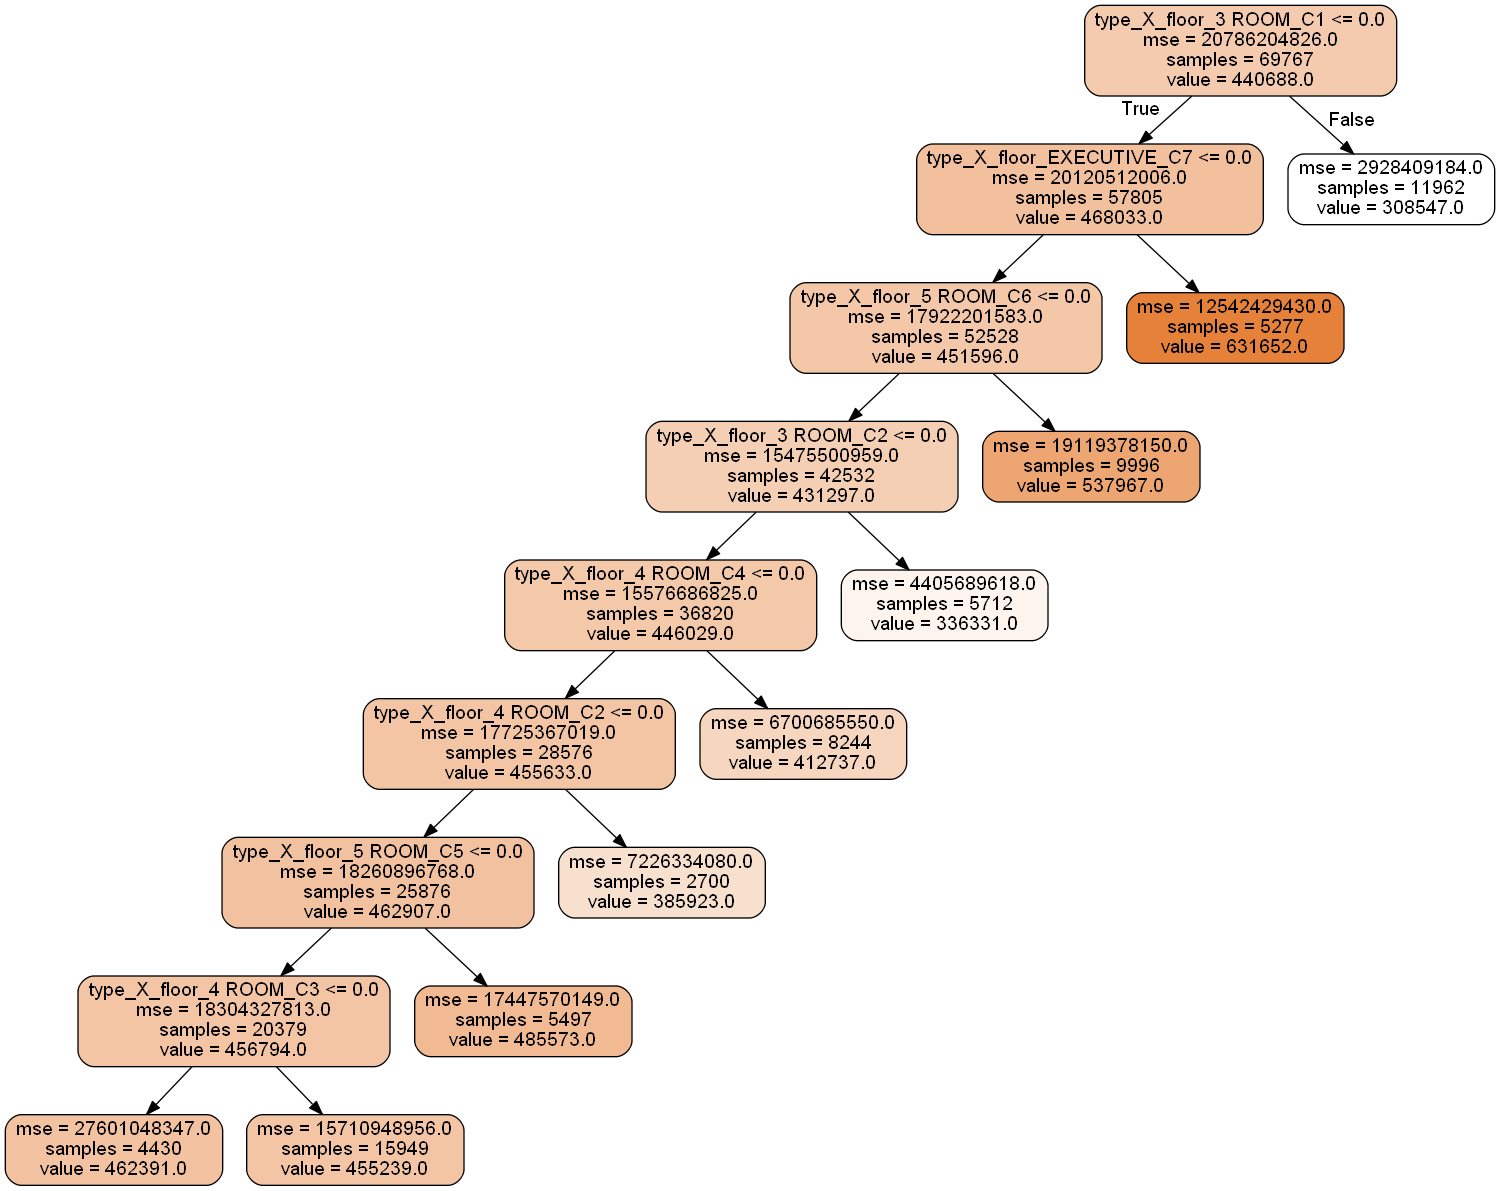

In [78]:
# Create new feature for flat type X floor area
hdb['type_X_floor'] = hdb.flat_type + '_' + hdb.floor_area

# Prepare data
X_train = pd.get_dummies(hdb[['type_X_floor']])
y_train = hdb.resale_price

# Configure decision tree regressor
dt_interact = DecisionTreeRegressor(
    criterion = 'mse',
    max_depth = 20,
    min_samples_leaf = 2000,
    random_state = 123
)

# Fit data
dt_interact.fit(X_train, y_train)

# Plot
dt_data = tree.export_graphviz(
    dt_interact, feature_names=X_train.columns,
    out_file=None, filled=True,
    rounded=True, precision = 0
)

# Draw graph
int_graph = pydotplus.graph_from_dot_data(dt_data)  

# Show graph
Image(int_graph.create_png(), width = 750)

The decision tree model gave us 9 categories:  
  
1. 3-Room flat with floor area category C1
2. Executive flat with floor area category C7
3. 5-Room flat with floor area category C6
4. 3-Room flat with floor area category C2
5. 4-Room flat with floor area category C4
6. 4-Room flat with floor area category C2
7. 5-Room flat with floor area category C5
8. 4-Room flat with floor area category C3
9. Others  
  
See the table below for the summary statistics of resale price for each category.

In [119]:
# Extract end nodes
hdb['type_X_floor_id'] = dt_interact.apply(X_train)

# Re-name end nodes
hdb['type_X_floor_id'][hdb.type_X_floor_id == 8] = 'Other'
hdb['type_X_floor_id'][hdb.type_X_floor_id == 9] = '4-room and C3'
hdb['type_X_floor_id'][hdb.type_X_floor_id == 10] = '5-room and C5'
hdb['type_X_floor_id'][hdb.type_X_floor_id == 11] = '4-room and C2'
hdb['type_X_floor_id'][hdb.type_X_floor_id == 12] = '4-room and C4'
hdb['type_X_floor_id'][hdb.type_X_floor_id == 13] = '3-room and C2'
hdb['type_X_floor_id'][hdb.type_X_floor_id == 14] = '5-room and C6'
hdb['type_X_floor_id'][hdb.type_X_floor_id == 15] = 'Exec and C7'
hdb['type_X_floor_id'][hdb.type_X_floor_id == 16] = '3-room and C1'

# Summarise
int_sum = hdb.pivot_table(
    values = 'resale_price',
    index = 'type_X_floor_id',
    aggfunc = [len, np.min, np.mean, np.median, np.max, np.std]
).rename(columns = {'len': 'count', 'amin': 'min', 'amax': 'max'})

# View
int_sum

count       min           mean    median         max  \
type_X_floor_id                                                           
3-room and C1    11962.0  170000.0  308547.119702  300000.0   645000.00   
3-room and C2     5712.0  206000.0  336330.989279  323000.0   888888.88   
4-room and C2     2700.0  255000.0  385922.618519  360000.0   742000.00   
4-room and C3    15949.0  225000.0  455238.890135  418000.0  1028000.00   
4-room and C4     8244.0  275000.0  412737.461640  393000.0   852000.00   
5-room and C5     5497.0  315000.0  485573.205683  443888.0  1145000.00   
5-room and C6     9996.0  300000.0  537967.401725  495000.0  1180000.00   
Exec and C7       5277.0  390000.0  631651.504620  610000.0  1160000.00   
Other             4430.0  175000.0  462390.614898  440000.0  1150000.00   

                           std  
type_X_floor_id                 
3-room and C1     54117.039961  
3-room and C2     66381.179991  
4-room and C2     85023.593735  
4-room and C3    125347.254027  
4-room and C4     81862.680409  
5-room and C5    132101.267003  
5-room and C6    138279.756453  
Exec and C7      112003.601242  
Other            166154.386757

To evaluate the fit of the model, we compute the RMSEs of the different features. Performing the computations for the interactive feature categories, we find that the weighted average of RMSEs was **73.22%** of the RMSE for the dataset ($144,174).

In [110]:
# Define function to get square root of mean
def rmse(x):
    
    return np.sqrt(np.mean(x))

# Calculate total MSE
hdb['tss'] = (hdb.resale_price - np.mean(hdb.resale_price)) ** 2
total_rmse = rmse(hdb.tss)

# Calculate RMSE for interactive feature
# Extract means
int_means = int_sum['mean']

# Map to existing data
hdb['int_means'] = hdb.type_X_floor_id.map(int_means)

# Calculate squared errors
hdb['int_se'] = (hdb.resale_price - hdb.int_means) ** 2

# Summarise
int_rmse = hdb.pivot_table(
    values = 'int_se',
    index = 'type_X_floor_id',
    aggfunc = [len, rmse]
).rename(columns = {'len': 'counts'})

# Calculate weights
int_rmse['weight'] = int_rmse.counts/hdb.shape[0]

# View
int_rmse

counts           rmse    weight
type_X_floor_id                                  
3-room and C1    11962.0   54114.777874  0.171456
3-room and C2     5712.0   66375.369059  0.081873
4-room and C2     2700.0   85007.847167  0.038700
4-room and C3    15949.0  125343.324338  0.228604
4-room and C4     8244.0   81857.715273  0.118165
5-room and C5     5497.0  132089.250696  0.078791
5-room and C6     9996.0  138272.839525  0.143277
Exec and C7       5277.0  111992.988308  0.075637
Other             4430.0  166135.632381  0.063497

In [109]:
# Compute weighted average
np.sum(int_rmse.rmse * int_rmse.weight) / total_rmse

0.7322241485397311

Performing the same computations for floor area and flat type give us similar RMSEs of **72.39%** and **73.68%** respectively.

In [115]:
# Calculate RMSE for floor area
# Summarise
fa_sum = hdb.pivot_table(
    values = 'resale_price',
    index = 'floor_area',
    aggfunc = [len, np.min, np.mean, np.median, np.max, np.std]
).rename(columns = {'len': 'count', 'amin': 'min', 'amax': 'max'})

# Extract means
fa_means = fa_sum['mean']

# Map to existing data
hdb['fa_means'] = hdb.floor_area.map(fa_means)

# Calculate squared errors
hdb['fa_se'] = (hdb.resale_price - hdb.fa_means) ** 2

# Summarise
fa_rmse = hdb.pivot_table(
    values = 'fa_se',
    index = 'floor_area',
    aggfunc = [len, rmse]
).rename(columns = {'len': 'counts'})

# Calculate weights
fa_rmse['weight'] = fa_rmse.counts/hdb.shape[0]

# Compute weighted average
np.sum(fa_rmse.rmse * fa_rmse.weight) / total_rmse

0.7238646528694407

In [114]:
# Calculate RMSE for flat type
# Summarise
ft_sum = hdb.pivot_table(
    values = 'resale_price',
    index = 'flat_type',
    aggfunc = [len, np.min, np.mean, np.median, np.max, np.std]
).rename(columns = {'len': 'count', 'amin': 'min', 'amax': 'max'})

# Extract means
ft_means = ft_sum['mean']

# Map to existing data
hdb['ft_means'] = hdb.flat_type.map(ft_means)

# Calculate squared errors
hdb['ft_se'] = (hdb.resale_price - hdb.ft_means) ** 2

# Summarise
ft_rmse = hdb.pivot_table(
    values = 'ft_se',
    index = 'flat_type',
    aggfunc = [len, rmse]
).rename(columns = {'len': 'counts'})

# Calculate weights
ft_rmse['weight'] = ft_rmse.counts/hdb.shape[0]

# Compute weighted average
np.sum(ft_rmse.rmse * ft_rmse.weight) / total_rmse

0.7368107185512195

Overall, creating an interaction feature between flat type and floor area did not reduce the RMSE of the dataset, although it helped us to reduce 12 binary features from flat type and floor area into 9 from the interaction feature (more like (1) 12 into 20 through one-hot encoding and (2) 20 into 9 using a decision tree). The cost of using this interaction feature would be a loss of information because we end up compressing 20 features into 9. We also end up being unable to assess the importance of flat type and floor area independently. These costs in intuition and flexibility must be weighed against the *potential* increase in prediction accuracy.

# Conclusion
In this post, I demonstrated 5 techniques for encoding categorical features and showed how pairs of categorical features can be combined to form interaction features. Like the choice of technique for the binning of numeric features, there is no way to choose a categorical feature encoding or interaction scheme without testing all of them out as part of the overall machine learning pipeline. Only through cross validation can we select the scheme that will perform best on unseen data.  
  
With that, we have come to the end of this subseries on *(the first, and hopefully, last round of)* feature engineering. We will have to re-visit the feature engineering phase if the machine learning models are unable to satisfactorily detect patterns in the data. I hope this subseries has been of use. To encourage you to dive deeper in this area, I quote Andrew Ng, the former Chief Scientist of Baidu:  
  
> *"Coming up with features is difﬁcult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering."*  
> -Andrew Ng